In [1]:
import pandas as pd

In [2]:
notes_raw = pd.read_csv("../data/notes-00000.tsv", sep="\t")
notes_topic = pd.read_parquet("./outputs/notes_with_topics.parquet", engine="pyarrow")

C:\Users\jguo27\AppData\Local\Temp\ipykernel_10276\1544562928.py:1: DtypeWarning: Columns (0: believable, 1: harmful, 2: validationDifficulty) have mixed types. Specify dtype option on import or set low_memory=False.
  notes_raw = pd.read_csv("../data/notes-00000.tsv", sep="\t")


In [3]:
print("Shape of notes_raw:", notes_raw.shape)
print("Shape of notes_topic:", notes_topic.shape)

Shape of notes_raw: (2347611, 24)
Shape of notes_topic: (2347608, 6)


In [4]:
notes = notes_topic.merge(
    notes_raw,
    on="noteId",
    how="left",
    validate="one_to_one"
)


In [5]:
note2topic = notes.set_index("noteId")["topic"]


In [6]:
import pandas as pd
from pathlib import Path

TOPK = 10
top_topics = notes["topic"].value_counts(dropna=False).head(TOPK).index.tolist()

rating_files = sorted(Path("../data").glob("ratings-*.tsv"))

top_counts = pd.Series(0, index=top_topics, dtype="int64")
other_count = 0

total_rows = 0
total_mapped = 0

for f in rating_files:
    for chunk in pd.read_csv(f, sep="\t", usecols=["noteId"], chunksize=2_000_000):
        total_rows += len(chunk)

        topics = chunk["noteId"].map(note2topic).dropna()
        total_mapped += len(topics)

        vc = topics.value_counts()

        top_counts = top_counts.add(vc.reindex(top_topics, fill_value=0), fill_value=0).astype("int64")

        other_count += int(vc.sum() - vc.reindex(top_topics, fill_value=0).sum())

rating_counts = top_counts.copy()
rating_counts["Other Topics"] = other_count

ratings_frac = (rating_counts / rating_counts.sum()) * 100

print("total ratings rows read:", total_rows)
print("total ratings mapped:", total_mapped)
ratings_frac.sort_values(ascending=False)


total ratings rows read: 196388856
total ratings mapped: 176844986


news_&_social_concern       70.805313
science_&_technology         4.181277
diaries_&_daily_life         3.777016
Other Topics                 3.710159
fitness_&_health             3.290402
sports                       3.254395
business_&_entrepreneurs     3.179328
celebrity_&_pop_culture      2.575536
film_tv_&_video              2.497998
other_hobbies                1.732573
gaming                       0.996002
dtype: float64

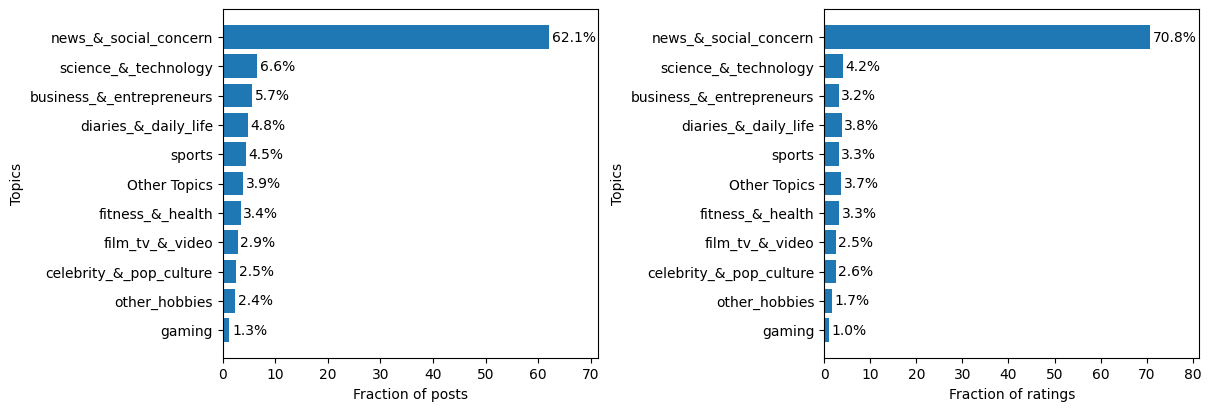

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

TOPK = 10

post_counts = notes["topic"].value_counts(dropna=False)
top_topics = post_counts.head(TOPK).index.tolist()

posts_topic_plot = notes["topic"].where(notes["topic"].isin(top_topics), "Other Topics")
posts_frac = posts_topic_plot.value_counts(normalize=True).sort_values(ascending=False) * 100


ratings_frac_plot = ratings_frac.reindex(posts_frac.index, fill_value=0)

def _barh_with_pct(ax, series_pct, xlabel):
    ax.barh(series_pct.index, series_pct.values)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Topics")

    for y, v in enumerate(series_pct.values):
        ax.text(v + 0.5, y, f"{v:.1f}%", va="center")

    ax.set_xlim(0, max(10, series_pct.max() * 1.15))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

_barh_with_pct(axes[0], posts_frac, "Fraction of posts")
_barh_with_pct(axes[1], ratings_frac_plot, "Fraction of ratings")

plt.show()


In [15]:
lvl2prio = {
    "HELPFUL": 3,
    "NOT_HELPFUL": 2,
    "SOMEWHAT_HELPFUL": 1,
}

In [16]:
rating_files = sorted(Path("../data").glob("ratings-*.tsv"))

notes_noteids = set(notes["noteId"].astype(str).unique())
note_best = {}   # noteId -> best priority

for f in rating_files:
    for chunk in pd.read_csv(
        f,
        sep="\t",
        usecols=["noteId", "helpfulnessLevel"],
        dtype={"noteId": "string", "helpfulnessLevel": "string"},
        chunksize=1_500_000,
    ):
        chunk = chunk[chunk["noteId"].isin(notes_noteids)]
        if chunk.empty:
            continue

        chunk["p"] = chunk["helpfulnessLevel"].map(lvl2prio)
        chunk["p"] = chunk["p"].fillna(1)   # missing → NEEDS MORE RATINGS

        g = chunk.groupby("noteId", sort=False)["p"].max()

        for nid, p in g.items():
            p = int(p)
            old = note_best.get(nid)
            if old is None or p > old:
                note_best[nid] = p


In [17]:
notes2 = notes.copy()
notes2["noteId"] = notes2["noteId"].astype("string")

notes2["p_note"] = notes2["noteId"].map(note_best).fillna(1).astype("int8")

post_best = (
    notes2.groupby("tweetId", as_index=False)
          .agg(topic=("topic", "first"), p=("p_note", "max"))
)

prio2status = {
    3: "HELPFUL",
    2: "NOT HELPFUL",
    1: "NEEDS MORE RATINGS",
}

post_best["note_status"] = post_best["p"].map(prio2status)


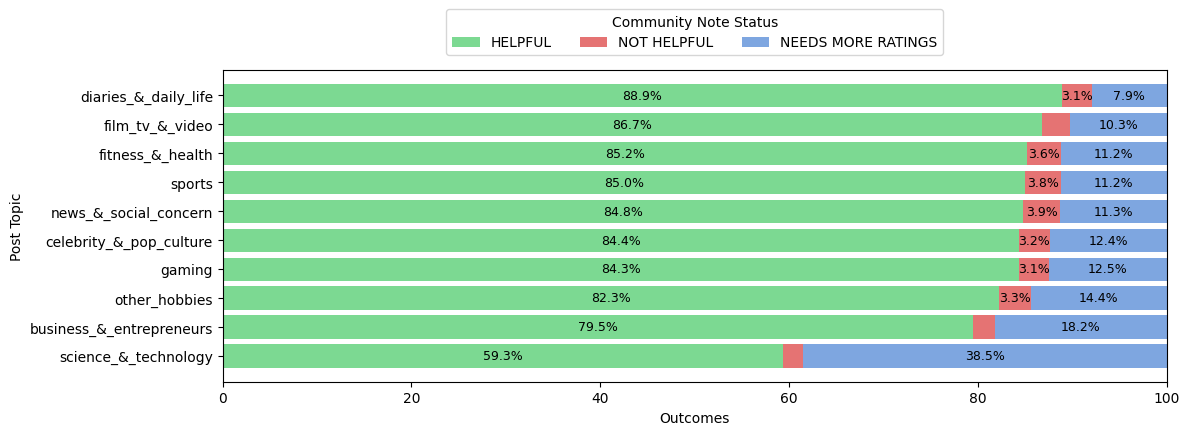

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TOPK = 10
STATUS_ORDER = ["HELPFUL", "NOT HELPFUL", "NEEDS MORE RATINGS"]

# 1) 取 top topics（按 post 数量）
top_topics = (
    post_best["topic"]
    .value_counts(dropna=False)
    .head(TOPK)
    .index
    .tolist()
)

# 2) 只保留 top topics，其他并到 Other Topics（如果你想跟论文一样显示 Other Topics）
plot_df = post_best[post_best["topic"].isin(top_topics)].copy()
plot_df["topic_plot"] = plot_df["topic"]

# 3) topic × status 计数
ct = (
    plot_df.groupby(["topic_plot", "note_status"])
           .size()
           .unstack(fill_value=0)
)

# 保证列顺序完整
for s in STATUS_ORDER:
    if s not in ct.columns:
        ct[s] = 0
ct = ct[STATUS_ORDER]

# 4) 转成百分比
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

# 5) 排序（按 HELPFUL 从高到低，和论文图观感一致）
ct_pct = ct_pct.sort_values("HELPFUL", ascending=False)

# ---- 画 stacked barh ----
fig, ax = plt.subplots(figsize=(12, 4.5))

y = np.arange(len(ct_pct.index))
left = np.zeros(len(ct_pct.index))

colors = {
    "HELPFUL": "#7cd992",
    "NOT HELPFUL": "#e57373",
    "NEEDS MORE RATINGS": "#7ea6e0",
}

for status in STATUS_ORDER:
    vals = ct_pct[status].values
    ax.barh(y, vals, left=left, label=status, color=colors[status])

    # 百分比标注（太小就不标）
    for i, (l, v) in enumerate(zip(left, vals)):
        if v >= 3:
            ax.text(l + v / 2, i, f"{v:.1f}%", ha="center", va="center", fontsize=9)

    left += vals

ax.set_yticks(y)
ax.set_yticklabels(ct_pct.index)
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_xlabel("Outcomes")
ax.set_ylabel("Post Topic")
ax.legend(
    title="Community Note Status",
    ncols=3,
    bbox_to_anchor=(0.5, 1.12),
    loc="center",
)

plt.tight_layout()
plt.show()
